<a target="_blank" href="https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/time-series-analysis.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

If you have any problems opening it in colab, check the footer of this notebook.

# ISPR - Midterm 1 - Assignment 1: time series analysis.

I have aimed to make the code as self-explanatory as possible. The notebook includes both code and markdown explanations where necessary. I hope the work meets the requirements! 🙂

In [2]:
import pmdarima as pm
from ucimlrepo import fetch_ucirepo
import datetime as dt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [3]:
appliances_energy_prediction = fetch_ucirepo(id=374) 
dates = appliances_energy_prediction.data.features['date']
series = appliances_energy_prediction.data.targets 

In [4]:
dates = pd.to_datetime(dates, format='%Y-%m-%d%H:%M:%S')

In [5]:
ts = series.merge(dates, left_index=True, right_index=True).set_index('date')

## Preliminary explanations

In [64]:
ts.head(3)

,Appliances
date,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50


In [ ]:
ts.describe()

,Appliances
count,19735.000000
mean,97.694958
std,102.524891
min,10.000000
25%,50.000000
50%,60.000000
75%,100.000000
max,1080.000000


<Axes: >

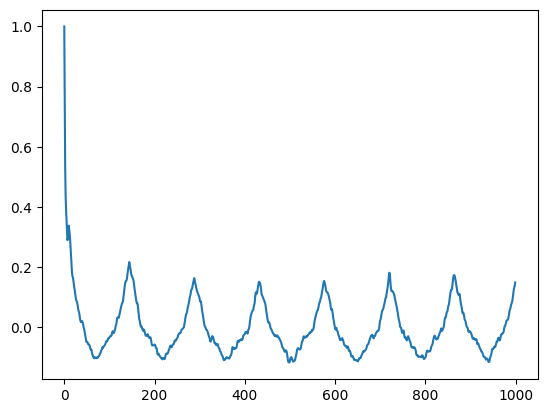

In [40]:
correlations = []
for i in range(1000):
    correlations.append(ts['Appliances'].corr(
        ts['Appliances'].shift(-i)
    ))
pd.Series(correlations).plot()

It seems like there is some seasonality in the series. 
Additionally, doing some thesholding, we can see that the peaks happens at distance 144 = a day:

<Axes: >

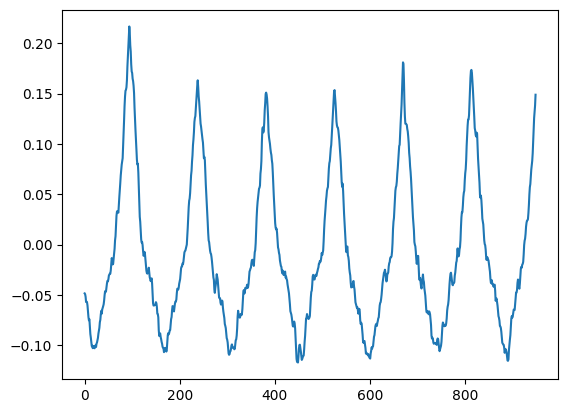

In [43]:
pd.Series(correlations[50:]).plot()

In [53]:
correlations_ = np.array(correlations[50:])
window_size = 10
peak_indices = []
peak_corrlations = []

for i in range(window_size, len(correlations_) - window_size):
    if correlations_[i] > max(correlations_[i - window_size:i]) and correlations_[i] > max(correlations_[i + 1:i + window_size + 1]):
        peak_indices.append(i)
        peak_corrlations.append(correlations_[i])
peak_distances = np.diff(peak_indices)
np.mean(peak_distances) , np.mean(peak_corrlations), np.min(peak_corrlations)

(144.0, 0.17320958105996787, 0.1510276451564821)

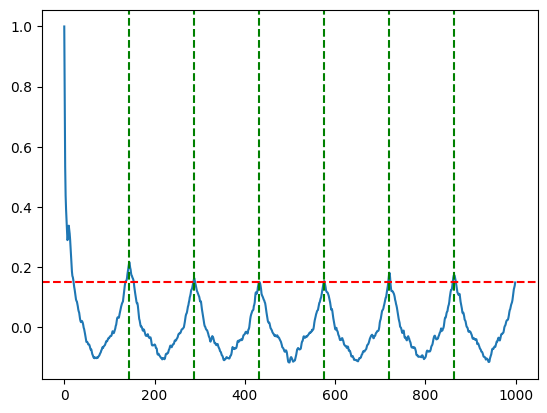

In [61]:
correlations = []
for i in range(1000):
    correlations.append(ts['Appliances'].corr(
        ts['Appliances'].shift(-i)
    ))
pd.Series(correlations).plot()
plt.axhline(np.min(peak_corrlations), color='red', linestyle='--')
for i in peak_indices:
    plt.axvline(i+50, color='green', linestyle='--')

Note: the seasonality will be tested for cursiosity just at the end, using SARIMA.

## Analysis of the time series without any added trend

<Axes: xlabel='date'>

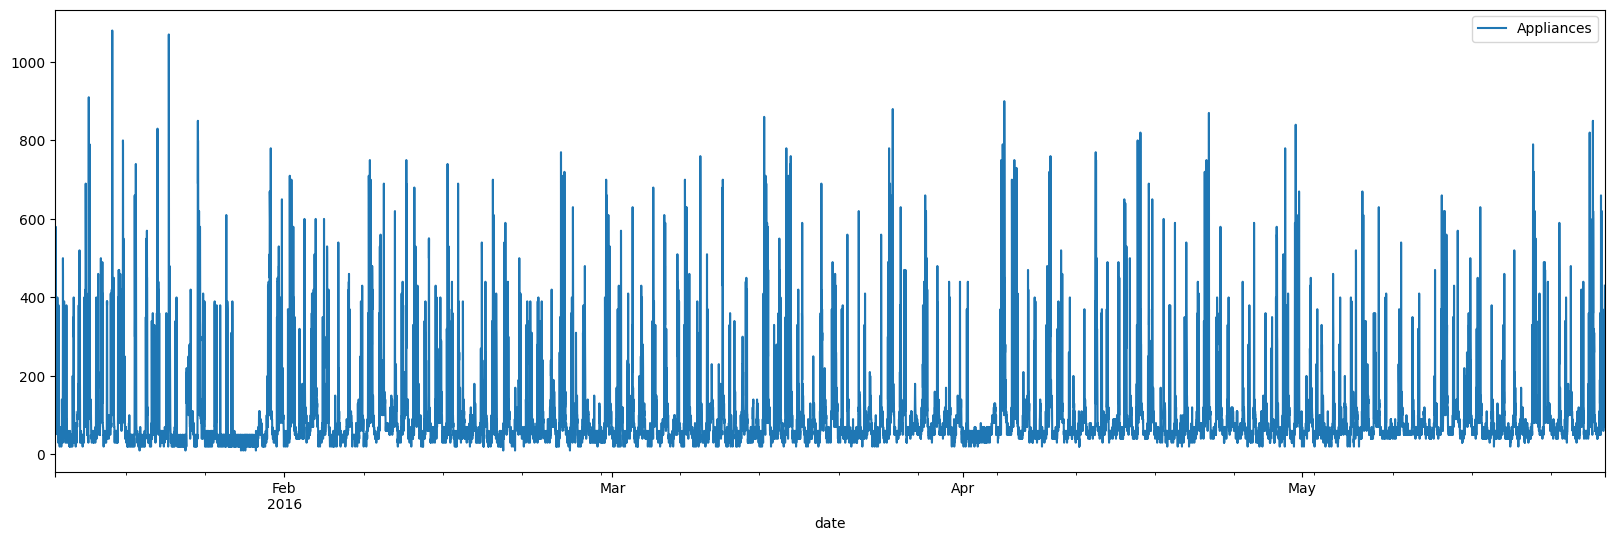

In [5]:
ts.plot(figsize=(20, 6))

The series appears to be stationary, but let's confirm with a statistical test.

In [8]:
result = adfuller(ts['Appliances'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -21.61637819803621
p-value: 0.0
Critical Values:
	1%: -3.430681600227742
	5%: -2.8616865555329394
	10%: -2.566848007525354


Since the p-value is 0.0, we can confidently conclude that the time series is stationary.

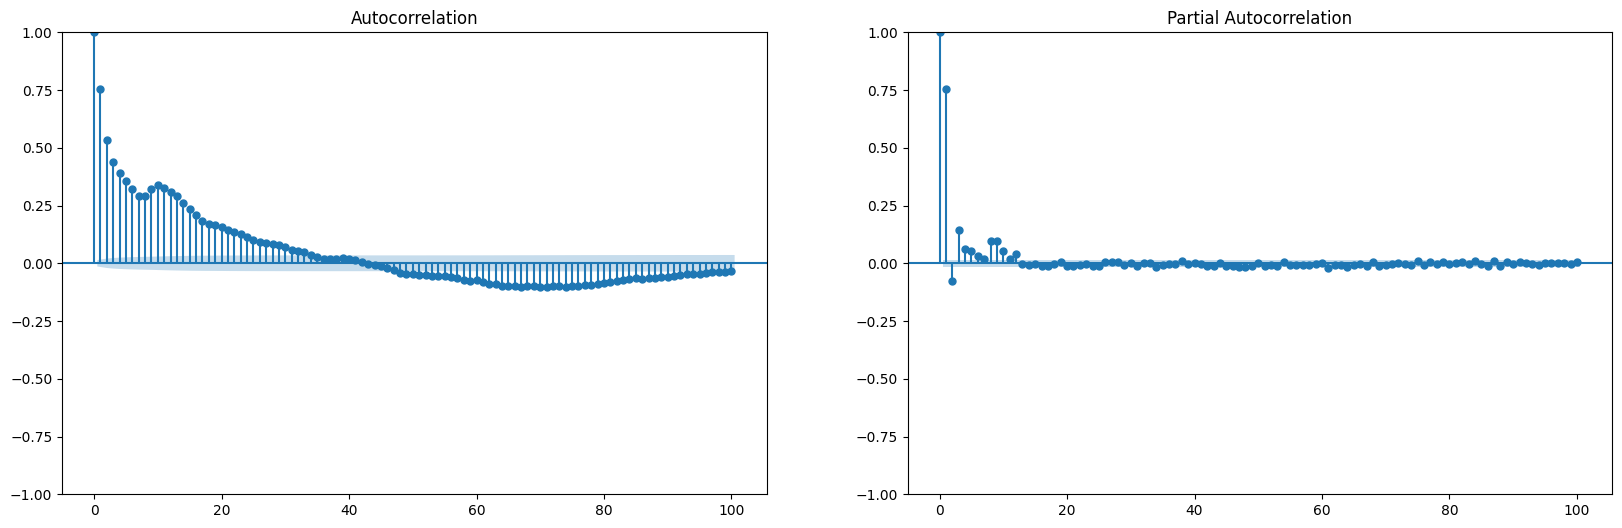

In [19]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_acf(ts['Appliances'], ax=plt.gca(), lags=100)
plt.subplot(1, 2, 2)
plot_pacf(ts['Appliances'], ax=plt.gca(), lags=100)
plt.show()

To determine the appropriate orders for the AR(MA) model, we analyze both the autocorrelation function (ACF) and the partial autocorrelation function (PACF) plots.  

- The PACF plot helps identify the AR component. A sharp cutoff after a few lags suggests an AR process.  
- In our PACF plot, there is a strong spike at lag 1 followed by a sharp drop, indicating an AR(1) or AR(2) process.  
- For the MA component, we do not observe a sharp cutoff in the ACF plot, suggesting a low or zero order for the MA component.  

However, to determine the best order, I used the `auto_arima()` method from the [`pmdarima` package](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html). This function optimizes the model based on a given information criterion (e.g., AIC), as discussed in our lecture.  

In [6]:
train, test = ts.loc[ts.index < dt.datetime(2016, 4, 1)], ts.loc[ts.index >= dt.datetime(2016, 4, 1)]

In [ ]:
train.shape[0]/(ts.shape[0]) # approx. 60% of the data is used for training

0.5858626805168482

In [ ]:
model = pm.auto_arima(train)

In [ ]:
# small preliminary test (10 values)
predictions = []

for item in tqdm(test.values[:10]):
    prediction = model.predict(n_periods=1).tolist()[0]
    predictions.append(prediction)
    model.update(item)
    

100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


In [ ]:
# full now
for item in tqdm(test.values[10:]):
    prediction = model.predict(n_periods=1).tolist()[0]
    predictions.append(prediction)
    model.update(item)

100%|██████████| 8163/8163 [7:10:42<00:00,  3.17s/it]  


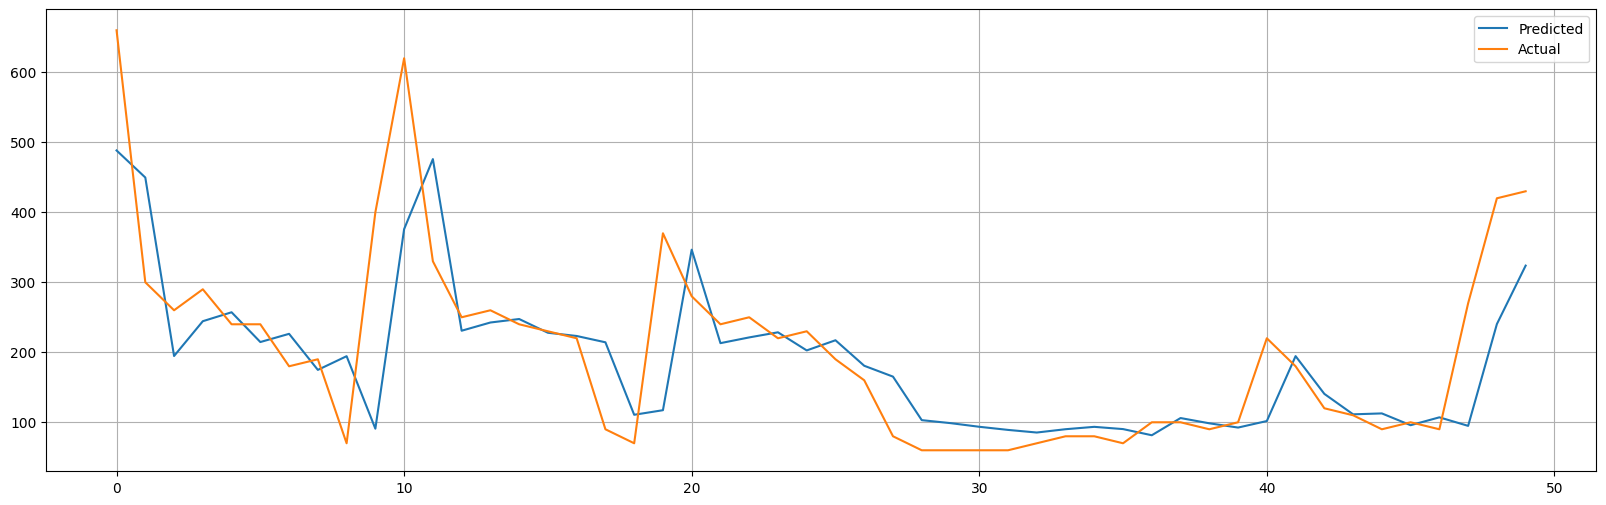

In [ ]:
# for convenience the plot is done just for a small window

window = 50
plt.figure(figsize=(20, 6))
pd.Series(predictions[-window:]).plot(label='Predicted')
pd.Series(test['Appliances'].values[-window:]).plot(label='Actual')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('MAE:', mean_absolute_error(test['Appliances'].values, predictions))

MAE: 27.047593644838997


In [38]:
model.order

(2, 0, 3)

Interestingly, when optimizing for the information criterion, we obtained an order of (2, 0, 3), suggesting an MA(3) component instead of 0.

Since our MAE with online retraining is approximately 27, we can now define error thresholds to experiment with a lighter retraining process—triggering retraining only when necessary.

In [40]:
thresholds = [25, 50, 100]
predictions_thresholds = {}
retrains = {}

for threshold in thresholds:
    print(f'Testing error threshold {threshold}:')
    predictions_thresholds[threshold] = []
    retrains[threshold] = 0
    not_retrained_buffer = []
    
    order = (2, 0, 3)
    model = pm.ARIMA(order=order)
    model.fit(train)
    
    for item in tqdm(test.values):
        not_retrained_buffer.append(item)
        prediction = model.predict(n_periods=1).tolist()[0]
        predictions_thresholds[threshold].append(prediction)
        
        error = abs(item - prediction)
        if error > threshold:
            # here we retrain, with the last values
            retrains[threshold] += 1
            model.update(not_retrained_buffer)
            not_retrained_buffer = []


Testing error threshold 25:


100%|██████████| 8173/8173 [2:04:25<00:00,  1.09it/s]  


Testing error threshold 50:


100%|██████████| 8173/8173 [1:14:55<00:00,  1.82it/s]  


Testing error threshold 100:


100%|██████████| 8173/8173 [48:59<00:00,  2.78it/s]  


We can notice that increasing the theshold reduce the computation time.

In [ ]:
retrains

{25: 1710, 50: 958, 100: 596}

As expected, increasing the error threshold reduced the number of retraining events.

Plot for threshold 25 , MAE: 27.612049869694147


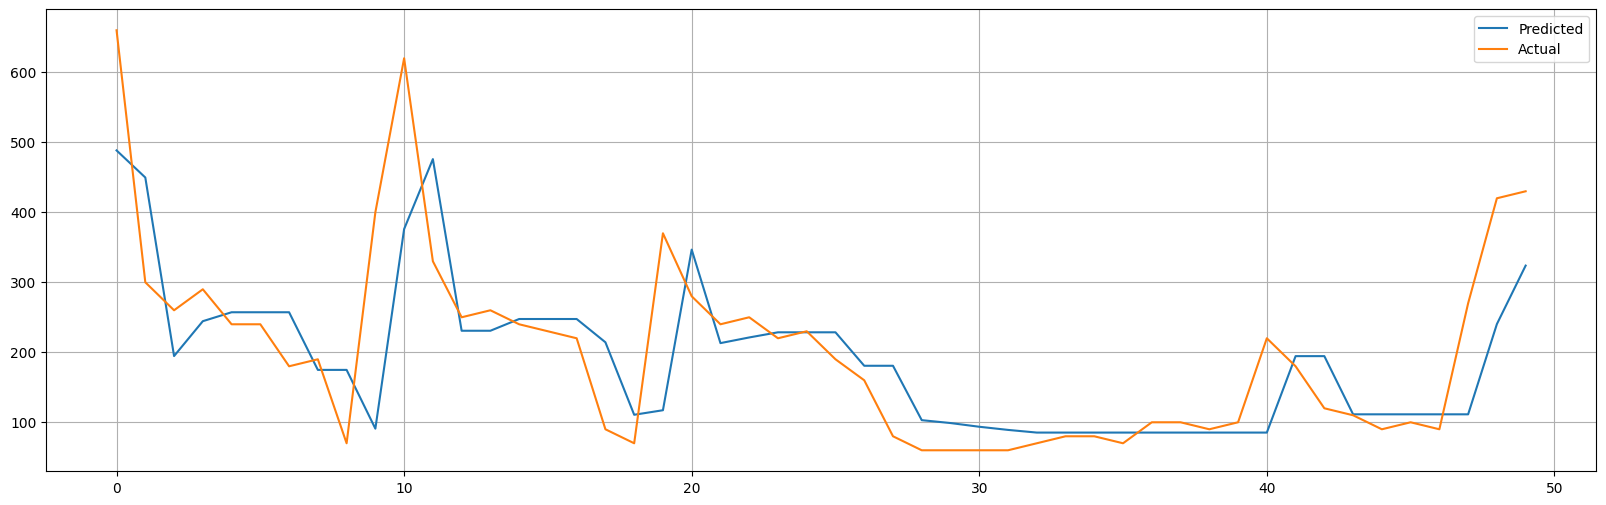

Plot for threshold 50 , MAE: 32.818617285916204


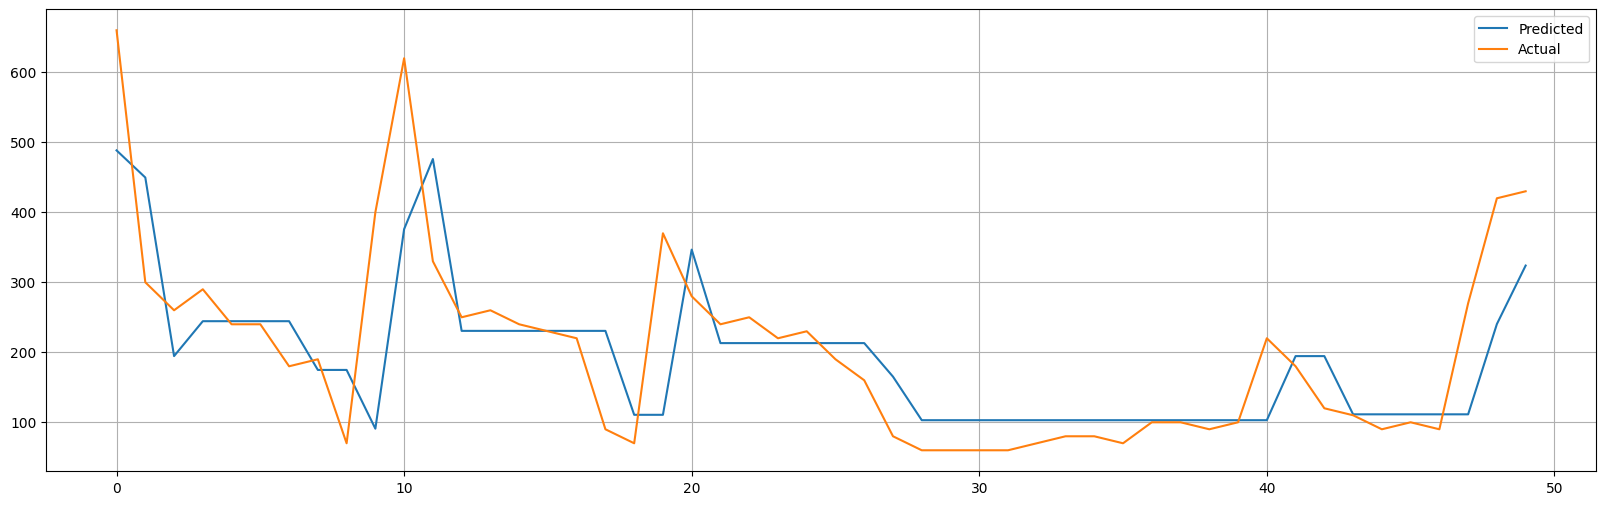

Plot for threshold 100 , MAE: 47.63314605929761


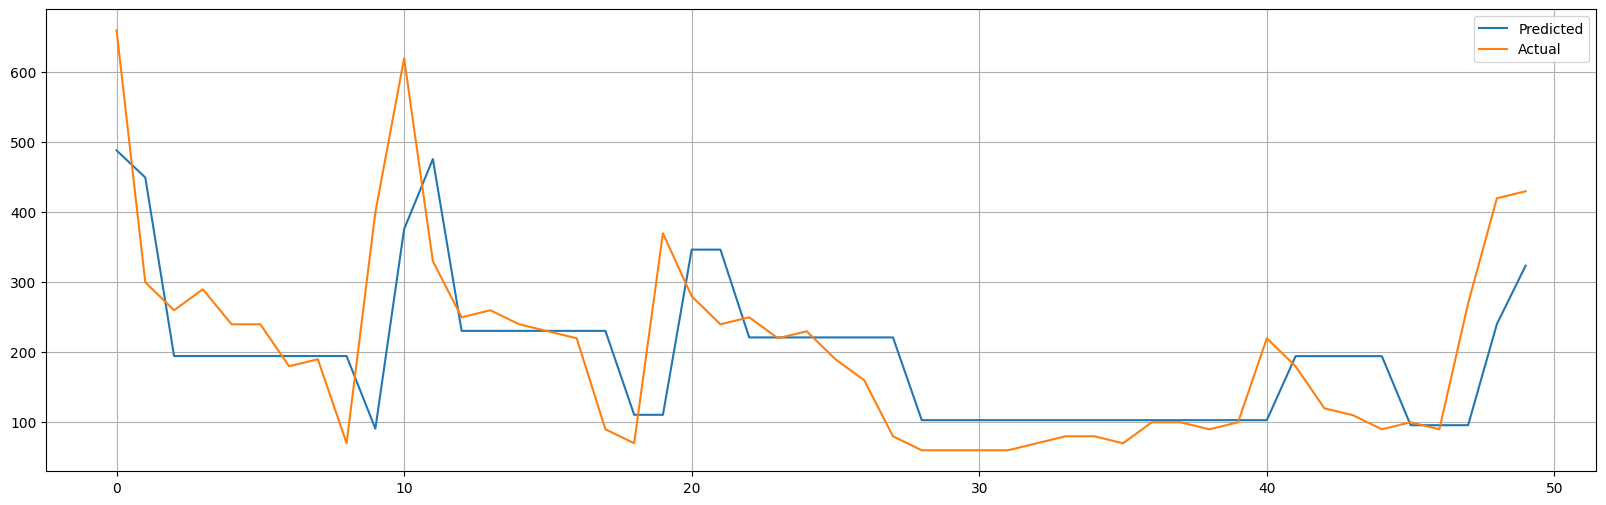

In [48]:
for threshold in thresholds:
    print('Plot for threshold', threshold, ", MAE:", mean_absolute_error(test['Appliances'].values, predictions_thresholds[threshold]))
    window = 50
    plt.figure(figsize=(20, 6))
    pd.Series(predictions_thresholds[threshold][-window:]).plot(label='Predicted')
    pd.Series(test['Appliances'].values[-window:]).plot(label='Actual')
    plt.legend()
    plt.grid()
    plt.show()

With an error threshold of 25 — slightly below the MAE of the online version — we observed a **2%** increase in MAE while reducing retraining by **80%**, making it a satisfactory result.

## Let's now add the linear trend

<Axes: xlabel='date'>

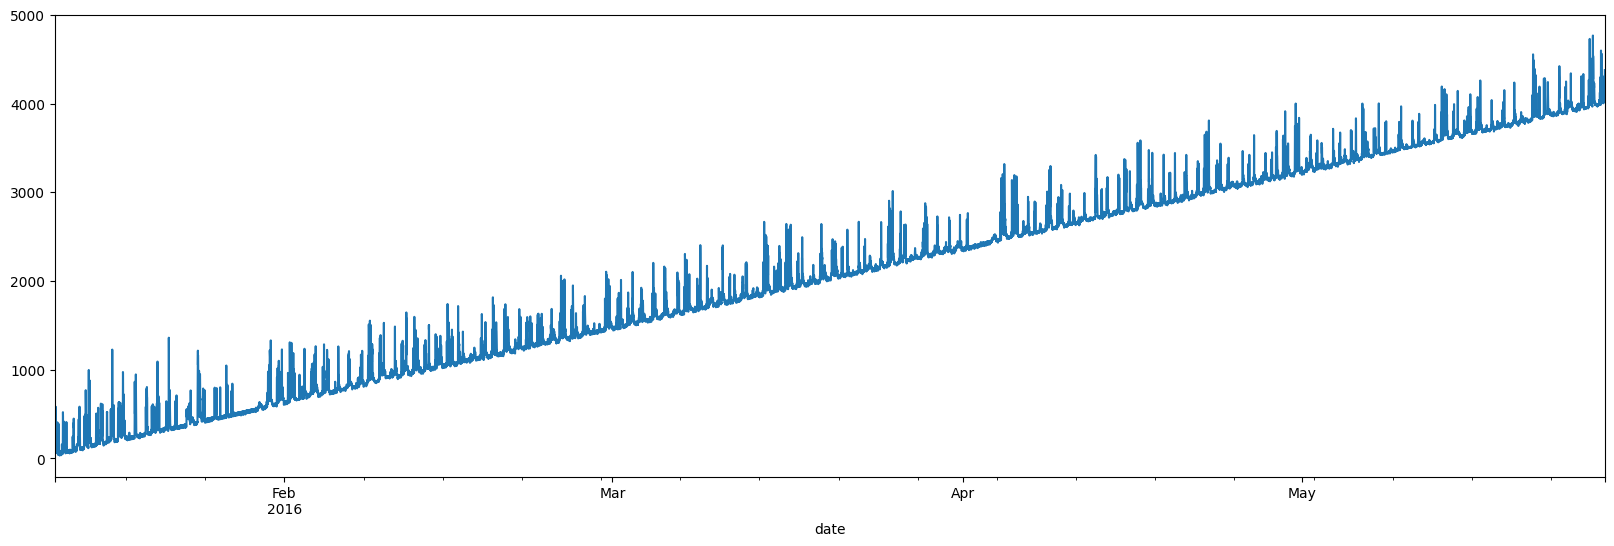

In [19]:
trended_ts = (ts['Appliances'] + np.arange(len(ts)) * 0.2) 
trended_ts.plot(figsize=(20, 6))

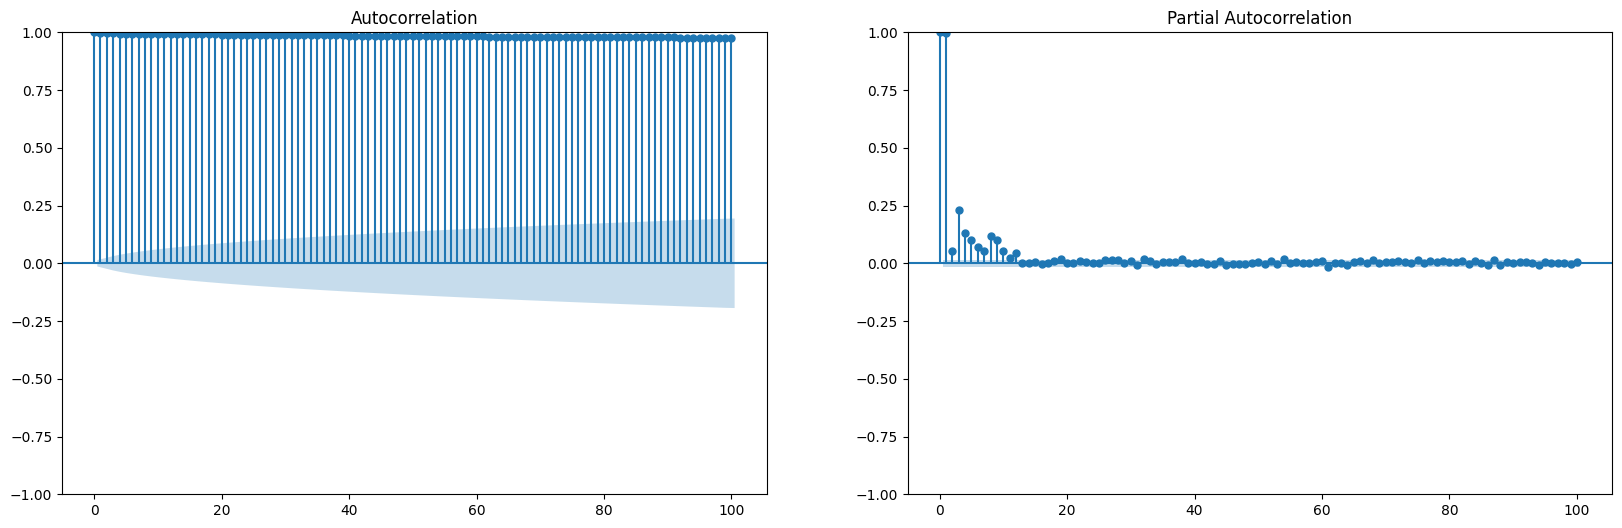

In [23]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_acf(trended_ts, ax=plt.gca(), lags=100)
plt.subplot(1, 2, 2)
plot_pacf(trended_ts, ax=plt.gca(), lags=100)
plt.show()

The autocorrelation plot is high for all the lag, meaning that the past values influence a lot the future ones. This is typical when the series has a trend (i.e. non-stationary).
We can confirm this with the Augmented Dickey-Fuller test:

In [24]:
# adfuller test:
result = adfuller(trended_ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -0.6987045152598633
p-value: 0.8470848123195314
Critical Values:
	1%: -3.430682139184172
	5%: -2.86168679371923
	10%: -2.566848134307755


The null hypothesis of the test is that Non-Stationarity exists in the series.
Since the p-values is greater than 0.05, we cannot reject the null hypothesis, meaning that the series is non-stationary.

In [ ]:
trended_train, trended_test = trended_ts.loc[ts.index < dt.datetime(2016, 4, 1)], trended_ts.loc[ts.index >= dt.datetime(2016, 4, 1)] # same split as before

Note that the code below has been executed on a faster machine, thus the prediction/retraining loop time is lower than the one reported above.

In [27]:
model = pm.auto_arima(trended_train, d = 0) # so it's either AR or ARMA or MA (no differencing)
predictions_t = [] # prediction for the trended series

for item in tqdm(trended_test.values):
    prediction = model.predict(n_periods=1).tolist()[0]
    predictions_t.append(prediction)
    model.update(item)

100%|██████████| 8173/8173 [1:21:49<00:00,  1.66it/s]


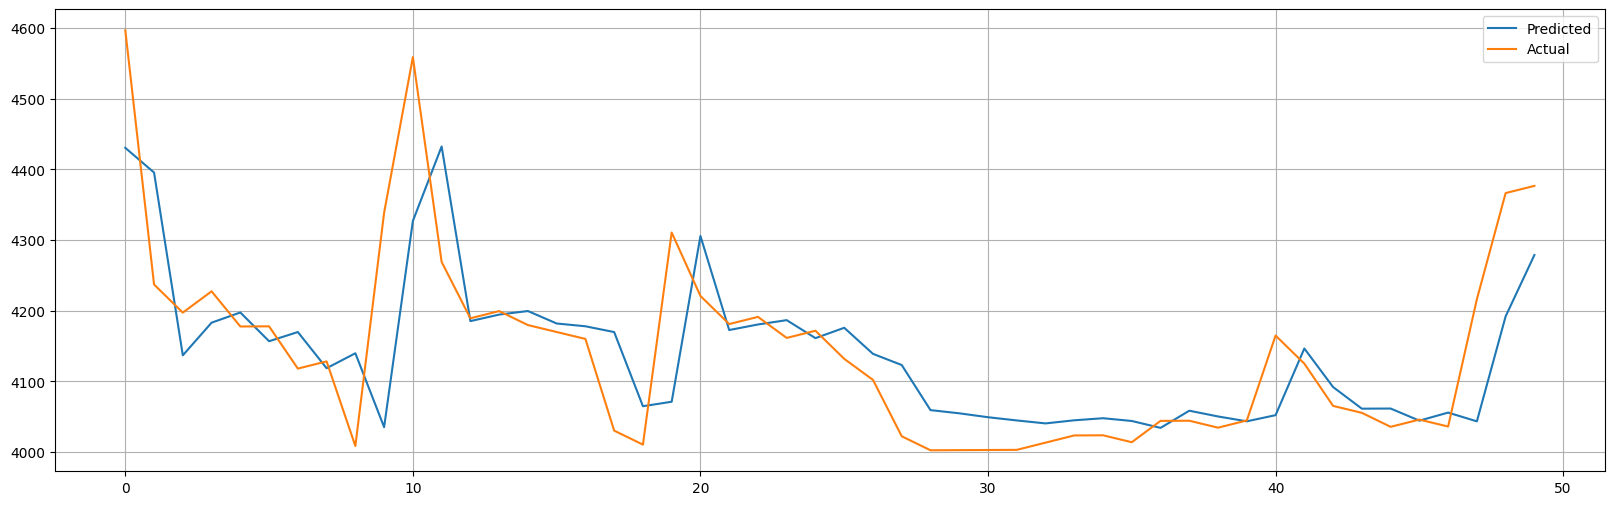

In [28]:
window = 50
plt.figure(figsize=(20, 6))
pd.Series(predictions_t[-window:]).plot(label='Predicted')
pd.Series(trended_test.values[-window:]).plot(label='Actual')
plt.legend()
plt.grid()
plt.show()

In [29]:
order_t = model.order
print(order_t)

(2, 0, 2)


In [30]:
print('MAE:', mean_absolute_error(trended_test.values, predictions_t))

MAE: 27.35292402843444


In [32]:
thresholds = [25, 50, 100]
predictions_thresholds_t = {}
retrains_t = {}

for threshold in thresholds:
    print(f'Testing error threshold {threshold}:')
    predictions_thresholds_t[threshold] = []
    retrains_t[threshold] = 0
    not_retrained_buffer = []
    
    model = pm.ARIMA(order=order_t)
    model.fit(trended_train)
    
    for item in tqdm(trended_test.values):
        not_retrained_buffer.append(item)
        prediction = model.predict(n_periods=1).tolist()[0]
        predictions_thresholds_t[threshold].append(prediction)
        
        error = abs(item - prediction)
        if error > threshold:
            # here we retrain, with the last values
            retrains_t[threshold] += 1
            model.update(not_retrained_buffer)
            not_retrained_buffer = []


Testing error threshold 25:


100%|██████████| 8173/8173 [23:57<00:00,  5.68it/s]  


Testing error threshold 50:


100%|██████████| 8173/8173 [14:13<00:00,  9.57it/s]  


Testing error threshold 100:


100%|██████████| 8173/8173 [08:42<00:00, 15.65it/s]


In [33]:
retrains_t

{25: 1844, 50: 995, 100: 593}

Also here, we have less retraining events, but more than the stationary version of the series.

Plot for threshold 25 , MAE: 28.38892926965438


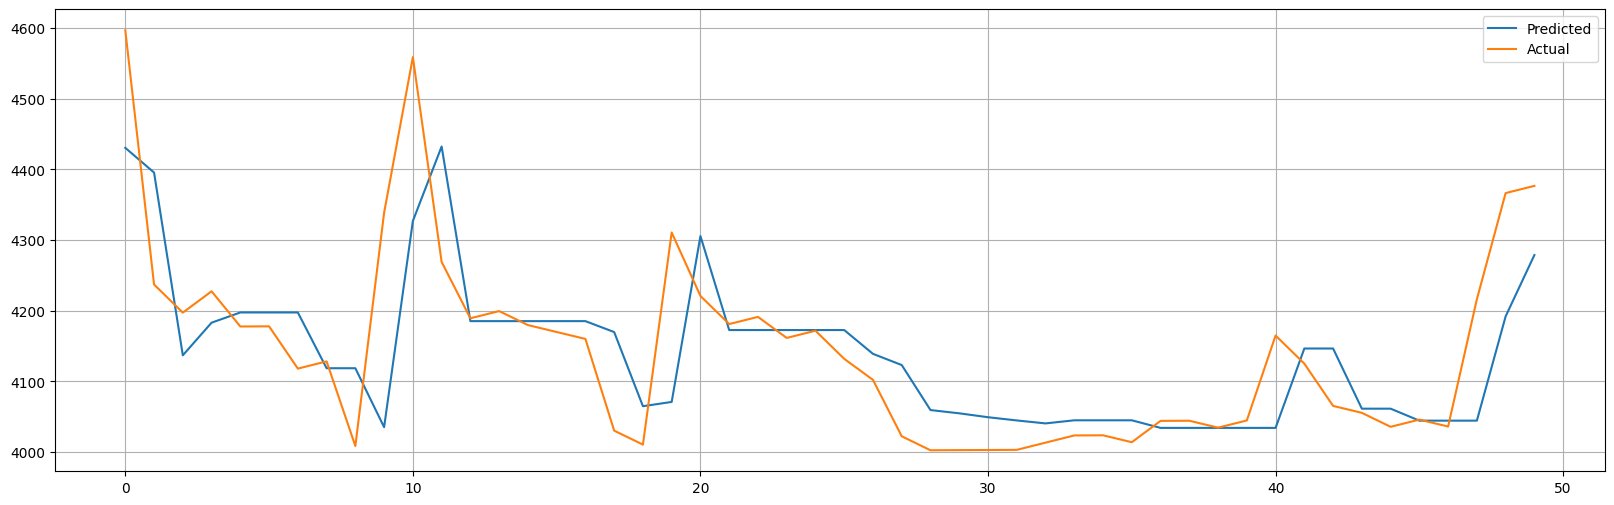

Plot for threshold 50 , MAE: 34.3926401500393


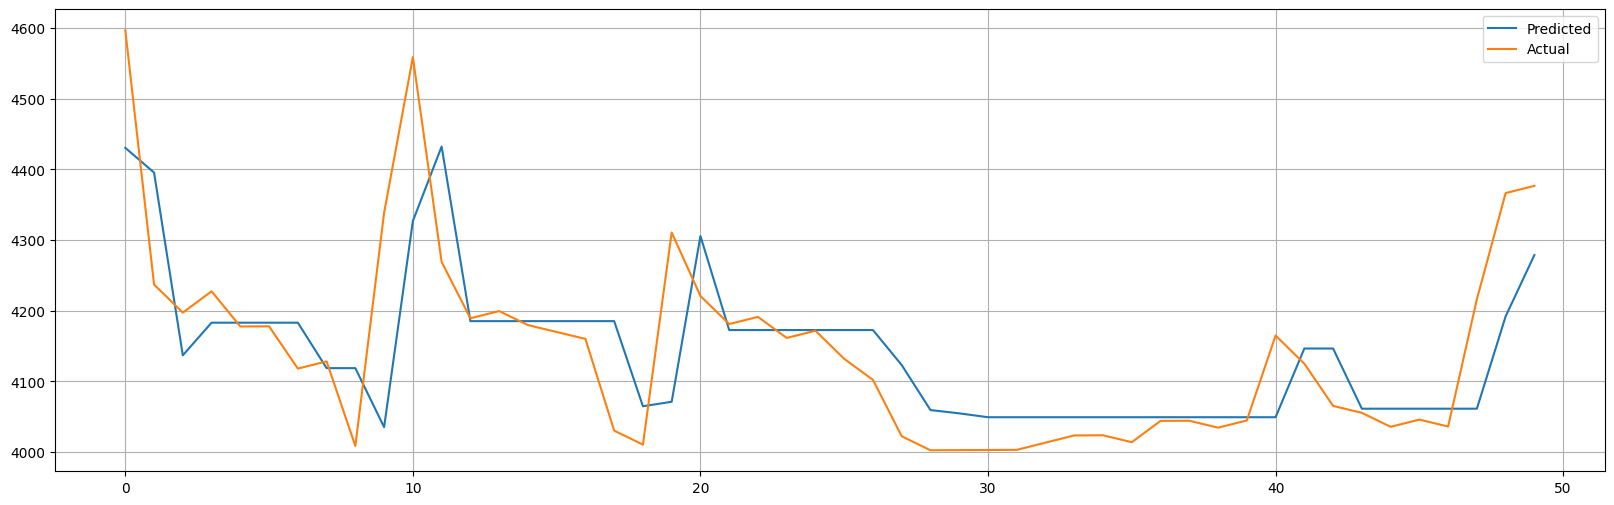

Plot for threshold 100 , MAE: 49.053826480450134


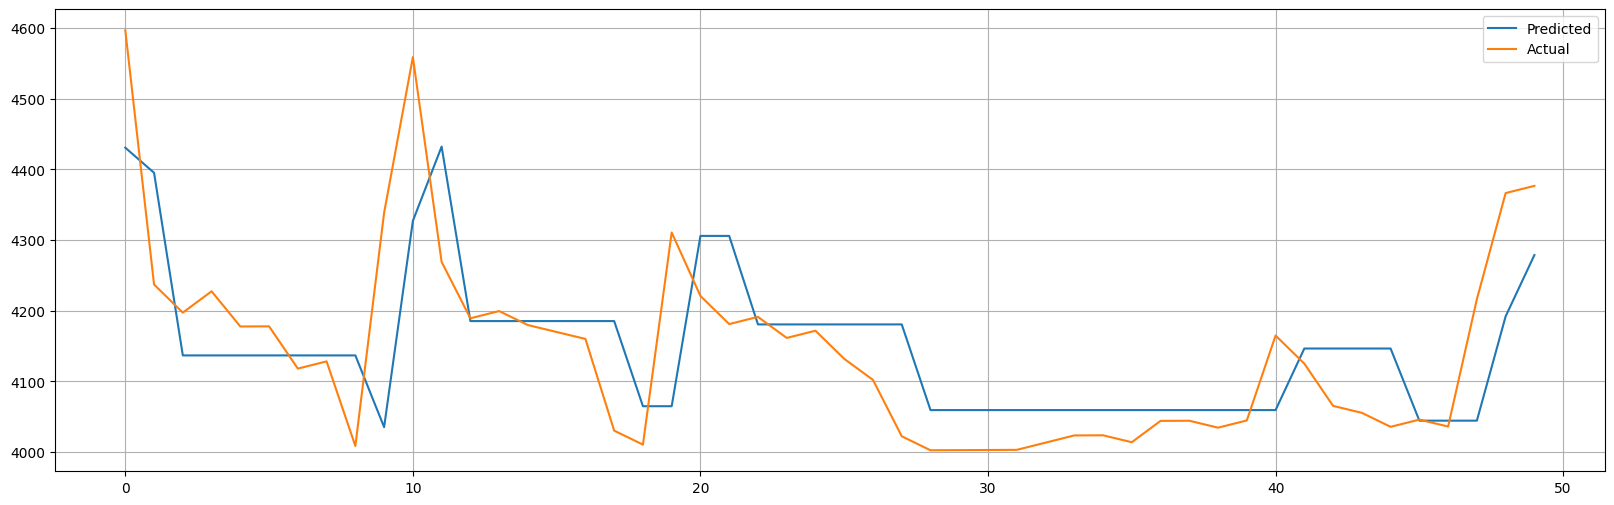

In [34]:
for threshold in thresholds:
    print('Plot for threshold', threshold, ", MAE:", mean_absolute_error(trended_test.values, predictions_thresholds_t[threshold]))
    window = 50
    plt.figure(figsize=(20, 6))
    pd.Series(predictions_thresholds_t[threshold][-window:]).plot(label='Predicted')
    pd.Series(trended_test.values[-window:]).plot(label='Actual')
    plt.legend()
    plt.grid()
    plt.show()

Of course, the MAE is higher compared to the stationary version, but, surprisingly, not that higher!

## Just for fun, let's try to leverage series seasonality with SARIMA on the stationary series

The kernel kept crashing even with 18 GB of RAM, so I decided to select a subseries of 1000 points (kernel crashed with 1500), split into training and testing sets. The last 500 points are used for testing to assess whether seasonality plays a role in improving predictions.

In [7]:
subseries = train['Appliances'][-1000:] # last 1000 values
subseries_train, subseries_test = subseries[:500], subseries[500:]

In [ ]:
model_s = pm.auto_arima(
    subseries_train, 
    seasonal=True, 
    m=144
)

print(model_s.order, model_s.seasonal_order)

predictions_s = []
for item in tqdm(subseries_test.values):
    prediction = model_s.predict(n_periods=1).tolist()[0]
    predictions_s.append(prediction)
    model_s.update(item)

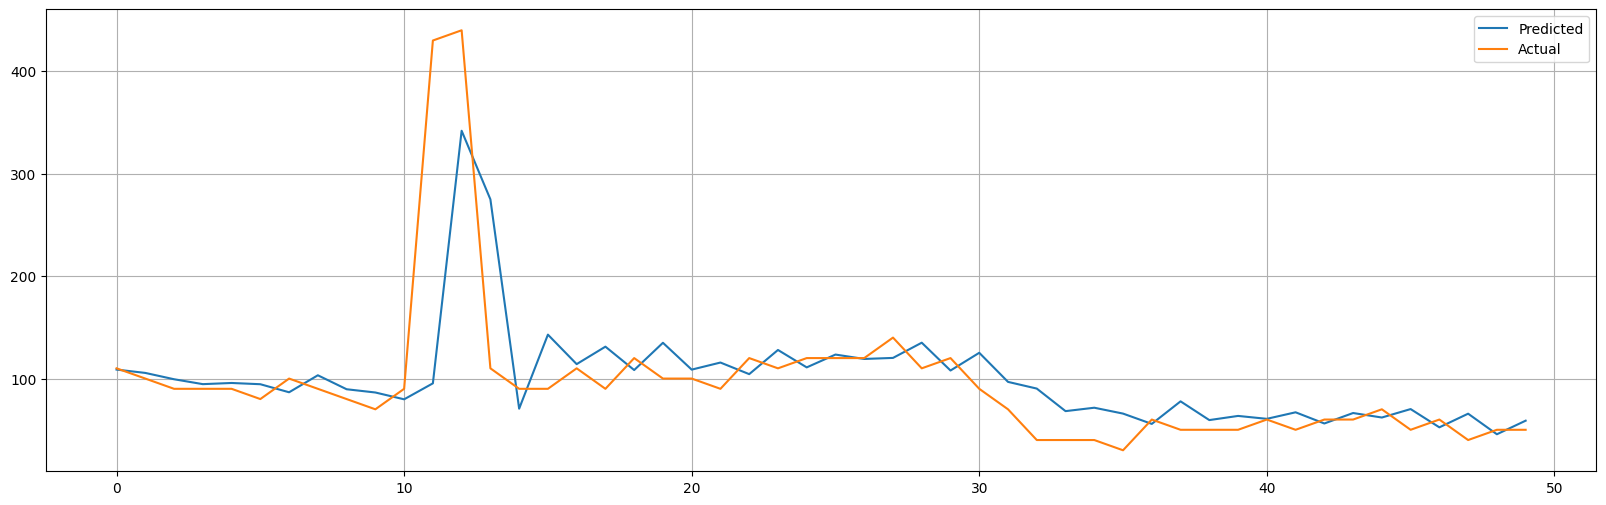

In [ ]:
pd.Series(predictions_s[-50:]).plot(figsize=(20, 6), label='Predicted')
pd.Series(subseries_test.values[-50:]).plot(label='Actual')
plt.grid()
plt.legend()
plt.show()

In [ ]:
print('MAE:', mean_absolute_error(subseries_test.values, predictions_s))

MAE: 28.168413461715623


Let's compare it with the ARIMA model on the same data:

In [8]:
arima_s = pm.auto_arima(
    subseries_train, 
    d=0
)

predictions_arima_s = []
for item in tqdm(subseries_test.values):
    prediction = arima_s.predict(n_periods=1).tolist()[0]
    predictions_arima_s.append(prediction)
    arima_s.update(item)
    
print('MAE:', mean_absolute_error(subseries_test.values, predictions_arima_s))

100%|██████████| 500/500 [00:18<00:00, 26.38it/s]

MAE: 27.778093306829852


The SARIMA model has a little higher MAE than the ARIMA model. 1000 points probably are not enough to leverage the seasonality of the series (peaks with correlation = 0.15 every 144 points).

### References:

- Youtube video (regarding the order of the ARMA model) - channel of Lasse Engbo Christiansen, Associate professor in statistics at the Technical University of Denmark: [https://www.youtube.com/watch?v=ZE_WGBe0_VU&ab_channel=LasseEngboChristiansen](https://www.youtube.com/watch?v=ZE_WGBe0_VU&ab_channel=LasseEngboChristiansen)

- Wikipedia (ARIMA models): [https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

- PmdArima Documentation: [https://alkaline-ml.com/pmdarima](https://alkaline-ml.com/pmdarima)

- Our lectures :)

### Links:

- Link to open the github repo: [https://github.com/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/time-series-analysis.ipynb](https://github.com/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/time-series-analysis.ipynb)

- Link to open it in colab: [https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/time-series-analysis.ipynb](https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/time-series-analysis.ipynb)